In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
sys.path.append(str(Path.cwd().parent))
from helpers import get_device

In [2]:
data_dir = Path(".").resolve(strict=True).parent.parent / "data"
assert data_dir.is_dir()

dataset_path = data_dir / "london_merged.csv"
assert dataset_path.is_file()

features_path = data_dir / "london_features.csv"
assert features_path.is_file()

models_dir = Path(".").resolve(strict=True).parent.parent / "models"
model_path = models_dir / "lstm_model.pth"

In [3]:
raw_dataset = pd.read_csv(dataset_path)
assert not raw_dataset.empty

features_dataset = pd.read_csv(features_path)
assert not features_dataset.empty

In [4]:
target = np.expand_dims(features_dataset["cnt"].values.astype(np.float32), axis=1)
features = features_dataset.drop(columns=["cnt"]).values.astype(np.float32)
np.random.seed(0)

In [5]:
def create_sequences(X, y, seq_len=24):
    xs, ys = [], []
    for i in range(seq_len, len(X)):
        xs.append(X[i-seq_len:i])  # (seq_len, num_features)
        ys.append(y[i])
    return np.array(xs), np.array(ys)

In [6]:
seq_len = 24
features_seq, target_seq = create_sequences(features, target, seq_len)
num_features = features_seq.shape[2]
hidden_size = 128

In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_size, 1)

    def __call__(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.linear(x[:, -1, :])
        return x.squeeze(-1)

In [8]:
def time_series_split(X, n_splits=5):
    num_samples = len(X)
    indices = np.arange(num_samples)
    sample_size = num_samples // (n_splits + 1)
    for i in range(1, n_splits + 1):
        train_stop = i * sample_size
        test_stop = min((i + 1) * sample_size, num_samples)
        yield indices[:train_stop], indices[train_stop:test_stop]

In [9]:
model = Model()
model.load_state_dict(torch.load(model_path, map_location=get_device()))
full_train_idx, full_test_idx = list(time_series_split(features_seq, n_splits=1))[-1]

In [10]:
with torch.no_grad():
    X_test = torch.tensor(features_seq[full_test_idx])
    y_pred_scaled = model(X_test).numpy()

In [11]:
# inverse transform (log + z-score)
target_log = np.log1p(raw_dataset["cnt"].values.astype(np.float32))
target_std = target_log.std()
target_mean = target_log.mean()

y_pred_log = (y_pred_scaled * target_std + target_mean).reshape(-1, 1)
y_test_log = (target_seq[full_test_idx].squeeze() * target_std + target_mean).reshape(-1, 1)
y_pred = np.expm1(y_pred_log).flatten()
y_true = np.expm1(y_test_log).flatten()

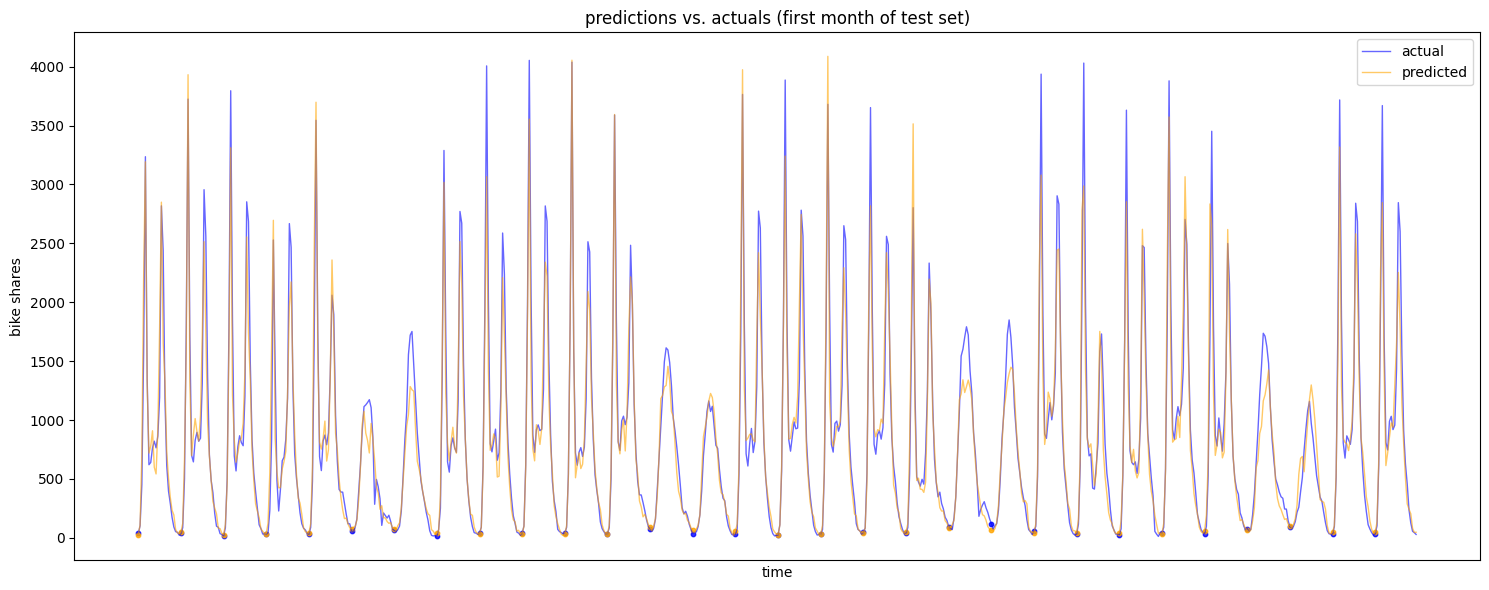

In [12]:
# plot predictions vs actuals
test_timestamps = raw_dataset["timestamp"].iloc[seq_len + full_test_idx].values
# Subsample to ~1 month (e.g., 30 days * 24 hours)
n_points = 30 * 24
sub_idx = slice(0, n_points)
sub_times = test_timestamps[sub_idx]
sub_actual = y_true[sub_idx]
sub_pred = y_pred[sub_idx]

# Plot with enhancements
plt.figure(figsize=(15, 6))  # Wider for time axis
plt.plot(sub_times, sub_actual, label="actual", alpha=0.6, linewidth=1, color="blue")
plt.plot(sub_times, sub_pred, label="predicted", alpha=0.6, linewidth=1, color="orange")

# Add markers every day (24 points) for anchors
daily_idx = range(0, n_points, 24)
plt.scatter(sub_times[daily_idx], sub_actual[daily_idx], color="blue", s=10, alpha=0.8)
plt.scatter(sub_times[daily_idx], sub_pred[daily_idx], color="orange", s=10, alpha=0.8)

plt.xlabel("time")
plt.ylabel("bike shares")
plt.title("predictions vs. actuals (first month of test set)")
plt.legend()
plt.xticks([])
plt.tight_layout()
plt.show()

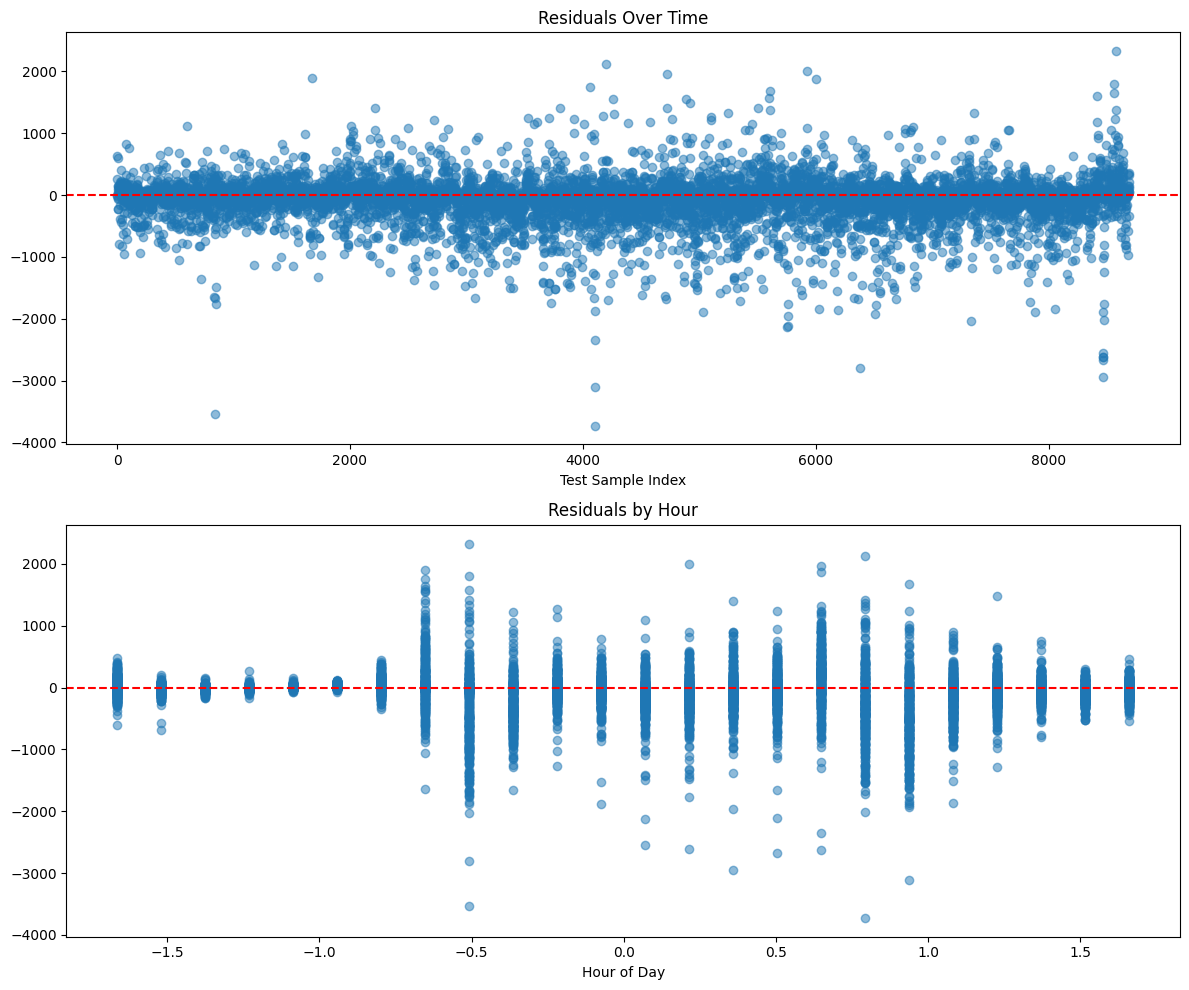

In [13]:
# residual analysis
residuals = y_pred - y_true

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(0, color="r", linestyle="--")
plt.title("Residuals Over Time")
plt.xlabel("Test Sample Index")

plt.subplot(2, 1, 2)
test_hours = features_dataset["hour"].iloc[seq_len + full_test_idx].values
plt.scatter(test_hours, residuals, alpha=0.5)
plt.axhline(0, color="r", linestyle="--")
plt.title("Residuals by Hour")
plt.xlabel("Hour of Day")
plt.tight_layout()
plt.show()

In [14]:
# pick 5 random test indices
sample_idx = np.random.choice(len(full_test_idx), 5, replace=False)
sample_test = full_test_idx[sample_idx]
raw_dataset["hour"] = pd.to_datetime(raw_dataset["timestamp"]).dt.hour

with torch.no_grad():
    for i, idx in enumerate(sample_test):
        seq = torch.tensor(features_seq[idx:idx+1])  # Single sequence
        pred_scaled = model(seq).item()
        pred = np.expm1(pred_scaled * target_std + target_mean)
        actual = np.expm1(target_seq[idx, 0] * target_std + target_mean)
        hour = raw_dataset["hour"].iloc[seq_len + idx]
        print(f"Sample {i+1} (Hour {hour}): actual={actual:.0f}, pred={pred:.0f}, error={pred-actual:.0f}")

Sample 1 (Hour 12): actual=1268, pred=1125, error=-143
Sample 2 (Hour 17): actual=2484, pred=2140, error=-344
Sample 3 (Hour 2): actual=147, pred=99, error=-48
Sample 4 (Hour 20): actual=2055, pred=1540, error=-515
Sample 5 (Hour 1): actual=86, pred=89, error=3


In [15]:
# baseline comparison (contextual benchmark)
# naive: predict last value in sequence (or average by hour-of-day)
rmse = np.sqrt(np.mean((y_pred - y_true)**2))
target_raw = raw_dataset["cnt"].values.astype(np.float32)
naive_pred = target_raw[seq_len + full_test_idx - 1]  # Last hour as pred
naive_rmse = np.sqrt(np.mean((naive_pred - target_raw[seq_len + full_test_idx]) ** 2))
print(f"LSTM RMSE: {rmse:.2f} vs. naive (last hour): {naive_rmse:.2f}")

# seasonal: average by hour across train (simpler baseline)
train_hours = raw_dataset["hour"].iloc[seq_len:seq_len + full_train_idx[-1]].values
seasonal_avg = {}  # hour -> mean cnt in train
for h in range(24):
    mask = train_hours == h
    if np.any(mask):
        seasonal_avg[h] = np.mean(target_raw[seq_len:seq_len + full_train_idx[-1]][mask])
seasonal_pred = np.array([seasonal_avg.get(hour, np.mean(target_raw)) for hour in raw_dataset["hour"].iloc[seq_len + full_test_idx]])
seasonal_rmse = np.sqrt(np.mean((seasonal_pred - target_raw[seq_len + full_test_idx]) ** 2))
print(f"LSTM RMSE: {rmse:.2f} vs. seasonal average: {seasonal_rmse:.2f}")

LSTM RMSE: 373.54 vs. naive (last hour): 731.65
LSTM RMSE: 373.54 vs. seasonal average: 693.19
